# Create the university network from student and lecturer data

In [103]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import datetime
import string
import network_creation_functions as ncf
from importlib import reload

In [104]:
src = '../data/raw/Grunddaten-Simulation'

In [105]:
! ls ../data/raw/Grunddaten-Simulation

 Bedienstete_mit_DV_an_Org.csv	  Räume.csv
 Lehrende.csv			  Studiendaten.csv
 LV.csv				  Studierende_pro_LV.csv
 LV.xlsx			  Studierende_pro_LV_mit_Idf.csv
 Prüfungen.csv			  study_labels.csv
 Prüfungstermine.csv		 'Termine_mit_LV Bezug.csv'
 Prüfungstermine_mit_Räumen.csv


In [106]:
semester_start = ncf.semester_start
semester_end = ncf.semester_end

## Load the relevant data

### Studies

In [107]:
studies = pd.read_csv(join(src, 'Studiendaten.csv'), encoding='latin_1')
studies = studies.rename(columns={
    'ST_PERSON_NR':'student_id',
    'STUDIENIDENTIFIKATOR':'study_id',
    'STUDIENBEZEICHNUNG':'study_name',
    'SEMESTERANZAHL':'term_number'
})
reload(ncf)
study_map = ncf.study_map
studies['study_level'] = studies['study_name'].apply(lambda x: x.split(';')[0])
studies['study_level'] = studies['study_level'].replace(study_map)

### Students

In [108]:
students = pd.read_csv(join(src, 'Studierende_pro_LV_mit_Idf.csv'))
students = students.rename(columns={
    'ST_PERSON_NR':'student_id',
    'STP_SP_NR':'lecture_id',
    'LV_GRP_NR':'group_id',
    'STUDIENIDENTIFIKATOR':'study_id'})
N = len(students['student_id'].unique())
print('{}/{} unique sutdents were active in WiSe 2019/20'\
      .format(N, len(studies['student_id'].unique())))
nostudy = students[~students['student_id'].isin(studies['student_id'])]
print("{} students don't have an assigned study"\
      .format(len(nostudy['student_id'].unique())))

students.head(3)

12710/21184 unique sutdents were active in WiSe 2019/20
92 students don't have an assigned study


,student_id,study_id,lecture_id,group_id
0,194228,UF 033 245,225442,263409
1,182296,UF 033 273,226073,254793
2,193960,UF 033 253,226598,260636


In [109]:
single_studies = studies[['study_id', 'study_name']]\
    .drop_duplicates()\
    .reset_index(drop=True)
single_studies.to_csv('../data/studies.csv', index=False)
# study labels (supplied by Tim):
# "t": TU Graz study
# "n": NaWi Graz study (study with uni Graz)
# "l": teaching study (study with 8 other universities)
# "k": study with university of arts
# "w": further training courses
# "a": other university
study_labels = pd.read_csv(join(src, 'study_labels.csv'))
single_studies ['study_label'] = study_labels['study_label']
label_map = {row['study_id']:row['study_label'] for i, row in \
            single_studies.iterrows()}
studies['study_label'] = studies['study_id'].replace(label_map)
N = len(studies['student_id'].unique())
studies = studies[studies['study_label'].isin(['t', 'n'])]
print('dropped {}/{} students that do not have a TU or NaWi Graz study'\
    .format(N - len(studies['student_id'].unique()), N))

dropped 11147/21184 students that do not have a TU or NaWi Graz study


In [110]:
studies['study_level'].value_counts()

bachelor                6602
master                  2851
PhD                      915
non-degree programme     269
bachelor & master         29
Name: study_level, dtype: int64

### Lectures

In [111]:
lectures = pd.read_excel(join(src, 'LV.xlsx')) # throws a parser error if read as csv
lectures = lectures.rename(columns={
    'STP_SP_NR':'lecture_id',
    'STP_SP_TITEL':'lecture_name_ger',
    'STP_SP_TITEL_ENGL':'lecture_name',
    'STP_LV_ART_KURZ':'lecture_type',
    'BETREUENDE_ORG_NR':'organisation_id',
    'BETREUENDE_ORG_NAME':'organisaton_name',
    'STP_SP_LVNR':'module_id'
})

lectures = lectures.drop(columns=['Unnamed: 11', 'STP_LV_ART_NAME', 'SJ_NAME',
                                  'SEMESTER_KB'])
N = len(lectures)
lectures = lectures[lectures['lecture_id'].isin(students['lecture_id'])]
print('{}/{} available lectures were visited by the students'\
      .format(len(lectures), N))
lectures.head(3)

1801/6334 available lectures were visited by the students


,lecture_id,module_id,lecture_name_ger,lecture_name,STP_SP_SST,lecture_type,organisation_id,organisaton_name
0,223321,710.095,Bildverstehen,Image Understanding,1,KU,2376,Institut f�r Maschinelles Sehen und Darstellen
1,223319,710.085,AK Computer Vision,Selected Topics Computer Vision,1,KU,2376,Institut f�r Maschinelles Sehen und Darstellen
2,225639,373.381,Buchhaltung und Bilanzierung,Accounting and Balancing,1,UE,11072,Institut f�r Betriebswirtschaftslehre und Betr...


### Lecturers

In [112]:
lecturers = pd.read_csv(join(src, 'Lehrende.csv'))
lecturers = lecturers.rename(columns={
    'PERSON_NR':'lecturer_id',
    'STP_SP_NR':'lecture_id',
    'LV_GRP_NR':'group_id'
})
N = len(lecturers['lecturer_id'].unique())
lecturers = lecturers[lecturers['lecture_id'].isin(students['lecture_id'])]
print('{}/{} lecturers are active in courses that were visited by students'\
      .format(len(lecturers['lecturer_id'].unique()), N))
lecturers.head(3)

1520/1853 lecturers are active in courses that were visited by students


,lecturer_id,lecture_id,group_id
1,23030,221435,258144
2,71025,228594,263699
3,109917,225445,257591


### Organisations

In [113]:
organisations = pd.read_csv(join(src, 'Bedienstete_mit_DV_an_Org.csv'),
                            encoding='latin_1')
organisations = organisations.rename(columns={
    'PERSON_NR':'lecturer_id',
    'ORG_NR':'organisation_id',
    'TUG_NEW.PUORG.GETNAME(A.ORG_NR)':'organisation_name'
})
# some lecturers have more than one affiliation. We keep a random affiliation
# and drop the others to keep things simple
organisations = organisations.sample(frac=1, random_state=42)
organisations = organisations.drop_duplicates(subset=['lecturer_id'])
print('lecturers are from {} organisations'\
      .format(len(organisations['organisation_id'].unique())))
organisations.head(3)

lecturers are from 220 organisations


,lecturer_id,organisation_id,organisation_name
2273,3261,2376,Institut für Maschinelles Sehen und Darstellen
1094,1743,34886,Veränderungsprozesse und Umsetzung
3095,102143,13706,Institut für Maschinenbau- und Betriebsinformatik


### Rooms

In [114]:
# note: manually filled in room information from rooms at KFU
rooms = pd.read_csv(join('../data/cleaned', 'Räume_cleaned.csv'), 
                    usecols=['RES_NR', 'RAUM_CODE', 'RAUM_SITZPLAETZE',
                            'QUADRATMETER', 'RAUM_GEBAEUDE_BEREICH_NAME'],
                    encoding='latin_1')
rooms = rooms.rename(columns={
    'RES_NR':'room_id',
    'RAUM_CODE':'room_code',
    'RAUM_SITZPLAETZE':'seats',
    'QUADRATMETER':'area',
    'RAUM_GEBAEUDE_BEREICH_NAME':'campus'
    
})
N = len(rooms)
rooms = rooms[rooms['campus'].isin(['Inffeldgasse', 'Alte Technik',
                                    'Neue Technik'])]
print('dropped {}/{} rooms that are not on TU Graz premises'\
      .format(N - len(rooms), N))

print('{}/{} rooms are associated with lectures that are visited by the students'\
     .format(len(rooms[rooms['room_id'].isin(dates['room_id'])]), 
             len(rooms)))
N = len(rooms[rooms['room_id'].isin(dates['room_id'])])
print('{}/{} relevant rooms have no seat information'\
      .format( N -\
              len(rooms[rooms['room_id'].isin(dates['room_id'])]\
                      .dropna(subset=['seats'])), N))
rooms.head(3)

dropped 72/2288 rooms that are not on TU Graz premises
371/2216 rooms are associated with lectures that are visited by the students
0/371 relevant rooms have no seat information


,room_id,room_code,seats,area,campus
0,1530,NA03190,27.0,52,Alte Technik
1,16649,NT02137F,4.0,25,Neue Technik
2,21135,HS01104,NaN,15,Inffeldgasse


### Dates 

In [115]:
semester_start = '2019-10-01'
semester_end = '2020-02-28'
dates = pd.read_csv(join(src, 'Termine_mit_LV Bezug.csv'),
                parse_dates=['DATUM_AM', 'ZEIT_VON', 'ZEIT_BIS'], dayfirst=True)
dates = dates.rename(columns={
    'RES_NR':'room_id',
    'DATUM_AM':'date',
    'ZEIT_VON':'start_time',
    'ZEIT_BIS':'end_time',
    'STP_SP_NR':'lecture_id',
    'LV_GRP_NR':'group_id'
})

N = len(dates)
dates = dates[dates['room_id'].isin(rooms['room_id'].unique())]
print('dropped {}/{} dates that occured in rooms outside TU Graz premises'\
      .format(N - len(dates), N))

dates['datetime'] = dates['start_time'].copy()
dates['start_time'] = dates['start_time'].apply(lambda x: x.time())
dates['end_time'] = dates['end_time'].apply(lambda x: x.time())
N = len(dates)
dates = dates[dates['start_time'] <= datetime.time(20, 0)]
print('dropped {} dates with a start time later than 8:00 PM'\
      .format(N - len(dates)))
N = len(dates)
dates = dates[dates['start_time'] >= datetime.time(7, 0)]
print('dropped {} dates with a start time earlier than 7:00 AM'\
      .format(N - len(dates)))
N = len(dates)
dates = dates[dates['start_time'] >= datetime.time(0, 0)]
print('dropped {} dates with a start time at 00:00'\
      .format(N - len(dates)))


dates['duration'] = dates.apply(ncf.calculate_duration, axis=1)
dates = dates[dates['duration'] <= 780]

assert len(dates) == len(dates[dates['date'] >= pd.to_datetime(semester_start)])
assert len(dates) == len(dates[dates['date'] <= pd.to_datetime(semester_end)])

N = len(dates)
dates = dates[dates['lecture_id'].isin(lectures['lecture_id'])]
print('{}/{} dates are associated with lectures that are visited by'\
      .format(len(dates), N) + \
      ' TU Graz or NaWi students on TU premises during the WiSe2019/20')

dropped 640/29147 dates that occured in rooms outside TU Graz premises
dropped 29 dates with a start time later than 8:00 PM
dropped 109 dates with a start time earlier than 7:00 AM
dropped 0 dates with a start time at 00:00
25379/28369 dates are associated with lectures that are visited by TU Graz or NaWi students on TU premises during the WiSe2019/20


,room_id,date,start_time,end_time,lecture_id,group_id,datetime,duration
0,963,2019-10-01,10:30:00,12:00:00,225816,257962,2019-10-01 10:30:00,90.0
1,26814,2019-10-01,09:45:00,10:00:00,228734,263991,2019-10-01 09:45:00,15.0
2,13854,2019-10-01,15:30:00,18:00:00,222870,254635,2019-10-01 15:30:00,150.0


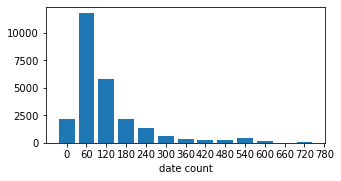

In [116]:
fig, ax = plt.subplots(figsize=(5, 2.5))
ax.hist(dates['duration'], rwidth=0.8, bins=range(0, 800, 60), align='left')
ax.set_xticks(range(0, 800, 60))
ax.set_xlabel('date duration [min]')
ax.set_xlabel('date count')

dates = dates.sort_values(by='date').reset_index(drop=True)
dates.head(3)

In [117]:
N = len(lectures)
lectures = lectures[lectures['lecture_id'].isin(dates['lecture_id'].unique())]
print('dropped {}/{} lectures that happened outside TU Graz premises or outside the semester'\
      .format(N - len(lectures), N))

dropped 133/1801 lectures that happened outside TU Graz premises or outside the semester


In [118]:
N = len(students)
students = students[students['lecture_id'].isin(dates['lecture_id'].unique())]
print('dropped {}/{} student visits to lectures that happened outside TU Graz premises or outside the semester'\
      .format(N - len(students), N))

dropped 1782/85505 student visits to lectures that happened outside TU Graz premises or outside the semester


In [119]:
N = len(lecturers['lecturer_id'].unique())
lecturers = lecturers[lecturers['lecture_id'].isin(dates['lecture_id'].unique())]
print('dropped {}/{} lecturers that taught lectures that happened outside TU Graz premises or outside the semester'\
      .format(N - len(lecturers['lecturer_id'].unique()), N))

dropped 31/1520 lecturers that taught lectures that happened outside TU Graz premises or outside the semester


there are 108 unique TU Graz or NaWi studies
10037 unique TU Graz or NaWi students are registered at TU Graz

number of studies per student
1    9448
2     549
3      40
Name: n_studies, dtype: int64

number of students per study
58    1023
57     808
59     804
61     661
55     653
63     539
13     373
78     356
64     314
60     301
Name: n_students, dtype: int64

the students active in WiSe 2019/20 had 76 different studies
the mean and median term number was 4.70 and 3.0, respectively
the mean and median number of students per study was 98.76 and 38.0, respectively


,student_id,study_id,study_name,term_number,study_level,study_label
3,208525,UB 198 420 423 01,Bachelorstudium Lehramt Sek (AB); UF Mathemati...,1,bachelor,t
18,162121,UF 033 678,Bachelorstudium; Physik,9,bachelor,n
19,201005,UF 033 213,Bachelorstudium; Elektrotechnik-Toningenieur,3,bachelor,t


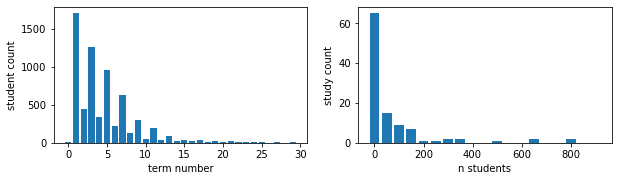

In [120]:
print('there are {} unique TU Graz or NaWi studies'.format(len(studies['study_id'].unique())))
print('{} unique TU Graz or NaWi students are registered at TU Graz'\
      .format(len(studies['student_id'].unique())))

n_studies = studies[['student_id', 'study_id']]\
    .groupby('student_id')\
    .count()\
    .rename(columns={'study_id':'n_studies'})\
    .reset_index()
print('\nnumber of studies per student')
print(n_studies['n_studies'].value_counts())

n_students = studies[['student_id', 'study_id']]\
    .groupby('study_id')\
    .count()\
    .rename(columns={'student_id':'n_students'})\
    .reset_index()\
    .sort_values(by='n_students', ascending=False)
print('\nnumber of students per study')
print(n_students['n_students'][0:10])

studies = studies[studies['student_id'].isin(students['student_id'].unique())]
print('\nthe students active in WiSe 2019/20 had {} different studies'\
      .format(len(studies['study_id'].unique())))

fig, axes = plt.subplots(1, 2, figsize=(10, 2.5))
axes[0].hist(studies['term_number'], rwidth=0.8, bins=range(0, 31, 1), align='left')
axes[0].set_xlabel('term number')
axes[0].set_ylabel('student count')

axes[1].hist(n_students['n_students'], rwidth=0.8, bins=range(0, 1000, 50),
             align='left')
axes[1].set_xlabel('n students')
axes[1].set_ylabel('study count')

print('the mean and median term number was {:1.2f} and {}, respectively'\
      .format(studies['term_number'].mean(), studies['term_number'].median()))

print('the mean and median number of students per study was {:1.2f} and {}, respectively'\
      .format(n_students['n_students'].mean(), n_students['n_students'].median()))


studies.head(3)

### Groups

In [121]:
# mapping of lecture group IDs to lecture IDs
groups = students[['lecture_id', 'group_id']].drop_duplicates().copy()

assert len(groups) == len(groups['group_id'].unique())

groups2 = lecturers[['lecture_id', 'group_id']].drop_duplicates().copy()
diff = list(set(groups['group_id']).difference(set(groups2['group_id'])))
print('there are {} groups that have no assigned lecturer'.format(len(diff)))

groups3 = dates[['lecture_id', 'group_id']].drop_duplicates().copy()
diff = list(set(groups['group_id']).difference(set(groups3['group_id'])))

N = len(groups)
groups = groups[groups['group_id'].isin(dates['group_id'].unique())]
print('dropped {}/{} groups that had no assigned date in the range {} - {}'\
      .format(N - len(groups), N, semester_start, semester_end))

print('there are {} unique groups and {} lectures left'\
      .format(len(groups['group_id'].unique()), 
              len(groups['lecture_id'].unique())))

groups = groups.reset_index(drop=True)

groups.head(3)

there are 29 groups that have no assigned lecturer
dropped 400/2529 groups that had no assigned date in the range 2019-10-01 - 2020-02-28
there are 2129 unique groups and 1565 lectures left


,lecture_id,group_id
0,226073,254793
1,226598,260636
2,221416,258125


### Disambiguate group IDs

In [ ]:
letter_list = list(string.ascii_lowercase)
dates['new_group_id'] = np.nan
for date in dates['date'].unique():
    print(date)
    for group_id in groups['group_id']:
        # dates that happen at the same time for the same group
        group_dates = dates[(dates['group_id'] == group_id) & \
                            (dates['date'] == date)]
        # is there more than one date for the same group id on a given day?
        # do the duplicate dates start at the same time?
        if (len(group_dates) > 1) and \
           (len(group_dates['start_time'].drop_duplicates()) < len(group_dates)):
            
            # de-duplicate group ids stat start at the same time by adding a 
            # letter at the end of the id
            for dt in group_dates['datetime']:
                group_datetimes = group_dates[group_dates['datetime'] == dt]
                assert len(group_datetimes) <= len(letter_list)
                #print('\t{}: entries {}'.format(group_id, len(group_datetimes)))
                
                for index, letter in zip(group_datetimes.index, letter_list):
                    dates.loc[index, 'new_group_id'] = '{}{}'.format(group_id, letter)

In [123]:
splits = dates[['group_id', 'new_group_id']].dropna().drop_duplicates()
print('{} groups had more than one date on the same day and at the same time and were split into {} new groups'\
      .format(len(splits['group_id'].unique()), len(splits)))

120 groups had more than one date on the same day and at the same time and were split into 285 new groups


In [124]:
students['new_group_id'] = np.nan
for group_id in splits['group_id'].unique():
    students_in_group = students[students['group_id']  == group_id]
    new_group_ids = splits[splits['group_id'] == group_id]['new_group_id'].values
    new_group_size = int(len(students_in_group) / len(new_group_ids))
    assert new_group_size >= 1
    
    for i, ID in enumerate(new_group_ids[0:-1]):
        students.loc[students_in_group[\
            i * new_group_size:(i + 1) * new_group_size].index, 'new_group_id']\
            = ID
    students.loc[students_in_group[(i + 1) * new_group_size:].index, 'new_group_id']\
            = new_group_ids[-1]

In [125]:
lonely_groups = 0
lecturers['new_group_id'] = np.nan
for group_id in splits['group_id'].unique():
    lecturers_in_group = lecturers[lecturers['group_id']  == group_id]
    new_group_ids = splits[splits['group_id'] == group_id]['new_group_id'].values
    new_group_size = int(len(lecturers_in_group) / len(new_group_ids))
    
    #since we are not cloning lecturers, if there is just one lecturer but two
    # groups at the same time, the lecturer will go to only one of the groups
    if new_group_size == 1:
        lonely_groups += 1
        
    for i, ID in enumerate(new_group_ids[0:-1]):
        lecturers.loc[lecturers_in_group[\
            i * new_group_size:(i + 1) * new_group_size].index, 'new_group_id']\
            = ID
    lecturers.loc[lecturers_in_group[(i + 1) * new_group_size:].index, 'new_group_id']\
            = new_group_ids[-1]
    
print('{} split groups have no lecturer now'.format(lonely_groups))

39 split groups have no lecturer now


### Exams

In [188]:
estudents = pd.read_csv(join(src, 'Prüfungen.csv'), encoding='latin_1',
                    parse_dates=['PRUEFUNGSDATUM'], dayfirst=True)
estudents = estudents.rename(columns={
    'PV_TERM_NR':'exam_id',
    'ST_PERSON_NR':'student_id',
    'STP_SP_NR':'lecture_id',
    'PRUEFUNGSDATUM':'exam_date'})
estudents.head(3)

,exam_id,exam_date,student_id,lecture_id
0,1278904,2019-12-13,165317,213079
1,1278904,2019-12-13,186785,213079
2,1278904,2019-12-13,183491,213079


### Exam dates

In [189]:
def get_time(timestring):
    if timestring != timestring:
        return np.nan
    else:
        hour, minute = timestring.split(':')
        return datetime.time(int(hour), int(minute))

In [190]:
edates = pd.read_csv(join(src, 'Prüfungstermine_mit_Räumen.csv'), encoding='latin_1',
                     parse_dates=['DATUM'], dayfirst=True)
edates = edates.rename(columns={
    'PV_TERM_NR':'exam_id',
    'PERSON_NR':'lecturer_id',
    'STP_SP_NR':'lecture_id',
    'DATUM':'exam_date',
    'RES_NR':'room_id',
    'BEGINNZEIT':'start_time',
    'ENDEZEIT':'end_time'})

print('{}/{} exam dates have no room information'\
      .format(len(edates) - len(edates.dropna(subset=['room_id'])),
              len(edates)))

# disambiguate exam IDs
letter_list = list(string.ascii_lowercase)
edates['new_exam_id'] = np.nan
for exam_id in edates['exam_id'].unique():
    exam_info = edates[edates['exam_id'] == exam_id]
    if len(exam_info) > 1:
        assert len(exam_info) <= len(letter_list)
        for index, letter in zip(exam_info.index, letter_list):
            edates.loc[index, 'new_exam_id'] = '{}{}'.format(exam_id, letter)
            
esplits = edates[['exam_id', 'new_exam_id']].dropna().drop_duplicates()
print('{} exams had more than one date on the same day and at the same time and were split into {} new exam groups'\
      .format(len(esplits['exam_id'].unique()), len(esplits)))


edates['start_time'] = edates['start_time'].apply(get_time)
edates['end_time'] = edates['end_time'].apply(get_time)
edates['duration'] = edates.apply(ncf.calculate_duration, axis=1)

N = len(edates)
print("{}/{} exams don't specify a duration"\
      .format(N - len(edates.dropna(subset=['duration'])), N))
duration_default = edates['duration'].median()
print("the default duration (median) is {} minutes".format(duration_default))
edates['duration'] = edates['duration'].fillna(duration_default)

print('there are {} exams with a duration of > 600 min -> replaced with {} min'\
      .format(len(edates[edates['duration'] > 360]), duration_default))
print('there are {} exams with a duration of < 30 min -> replaced with {} min'\
      .format(len(edates[edates['duration'] < 30]), duration_default))
edates.loc[edates[edates['duration'] > 360].index, 'duration'] = duration_default
edates.loc[edates[edates['duration'] < 30].index, 'duration'] = duration_default


edates.head(3)

3661/5633 exam dates have no room information
45 exams had more than one date on the same day and at the same time and were split into 121 new exam groups
2889/5633 exams don't specify a duration
the default duration (median) is 120.0 minutes
there are 49 exams with a duration of > 600 min -> replaced with 120.0 min
there are 24 exams with a duration of < 30 min -> replaced with 120.0 min


,exam_id,lecturer_id,exam_date,start_time,end_time,room_id,lecture_id,new_exam_id,duration
0,1280079,1773,2019-12-02,10:15:00,12:00:00,2661.0,227402,NaN,105.0
1,1269842,44990,2020-02-28,14:00:00,NaN,2541.0,226034,NaN,120.0
2,1276611,107131,2019-10-16,16:30:00,17:30:00,261.0,212311,NaN,60.0


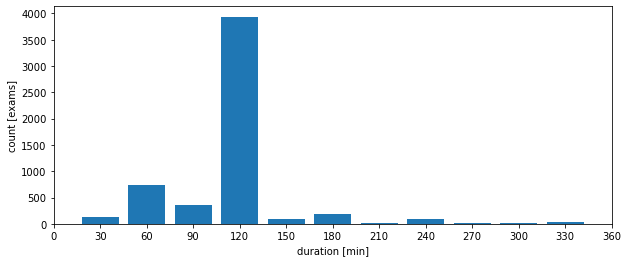

In [191]:
duration_counts = edates['duration']\
    .value_counts()\
    .reset_index()\
    .rename(columns={'duration':'count', 'index':'duration'})\
    .sort_values(by='duration', ascending=False)

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(edates['duration'], bins=range(30, 361, 30), rwidth=0.8, align='left')
ax.set_xticks(range(0, 361, 30))
ax.set_ylabel('count [exams]')
ax.set_xlabel('duration [min]');

In [192]:
estudents['new_exam_id'] = np.nan
for exam_id in esplits['exam_id'].unique():
    students_in_exam = estudents[estudents['exam_id']  == exam_id]
    new_exam_ids = esplits[esplits['exam_id'] == exam_id]['new_exam_id'].values
    new_exam_size = int(len(students_in_exam) / len(new_exam_ids))
    
    if new_exam_size >= 1:
        for i, ID in enumerate(new_exam_ids[0:-1]):
            estudents.loc[students_in_exam[\
                i * new_exam_size:(i + 1) * new_exam_size].index, 'new_exam_id']\
                = ID
        estudents.loc[students_in_exam[(i + 1) * new_exam_size:].index, 'new_exam_id']\
                = new_exam_ids[-1]
    else:
        print('exam {} has only 1 student'.format(exam_id))

exam 1274540 has only 1 student
exam 1284511 has only 1 student
exam 1282280 has only 1 student


In [193]:
electurers = edates[['exam_id', 'lecturer_id']].copy()
lonely_exams = 0
electurers['new_group_id'] = np.nan
for exam_id in esplits['exam_id'].unique():
    lecturers_in_exam = electurers[electurers['exam_id']  == exam_id]
    new_exam_ids = esplits[esplits['exam_id'] == exam_id]['new_exam_id'].values
    new_exam_size = int(len(lecturers_in_exam) / len(new_exam_ids))
    
    #since we are not cloning lecturers, if there is just one lecturer but two
    # groups at the same time, the lecturer will go to only one of the groups
    if new_exam_size == 1:
        lonely_exams += 1
        
    for i, ID in enumerate(new_exam_ids[0:-1]):
        electurers.loc[lecturers_in_exam[\
            i * new_exam_size:(i + 1) * new_exam_size].index, 'new_exam_id']\
            = ID
    electurers.loc[lecturers_in_exam[(i + 1) * new_exam_size:].index, 'new_exam_id']\
            = new_exam_ids[-1]
    
print('{} split exams have no lecturer now'.format(lonely_exams))

45 split exams have no lecturer now


In [194]:
exam_counts = edates[['exam_date', 'exam_id']]\
    .drop_duplicates()\
    .groupby('exam_date')\
    .count()\
    .reset_index()\
    .rename(columns={'exam_id':'exam_count'})\
    .sort_values(by='exam_date')

In [195]:
exam_active_students_counts = estudents[['exam_date', 'student_id']]\
    .drop_duplicates()\
    .groupby('exam_date')\
    .count()\
    .reset_index()\
    .rename(columns={'student_id':'student_count'})\
    .sort_values(by='exam_date')

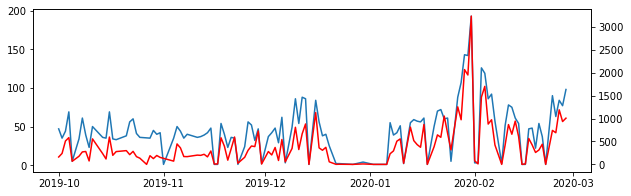

In [196]:
fig, ax = plt.subplots(figsize=(10, 3))
ax2 = ax.twinx()
ax.plot(exam_counts['exam_date'], exam_counts['exam_count'])
ax2.plot(exam_active_students_counts['exam_date'], 
        exam_active_students_counts['student_count'], color='r')

In [197]:
estudents['new_exam_id'] = np.nan
for exam_id in esplits['exam_id'].unique():
    students_in_exam = estudents[estudents['exam_id']  == exam_id]
    new_exam_ids = esplits[esplits['exam_id'] == exam_id]['new_exam_id'].values
    new_exam_size = int(len(students_in_exam) / len(new_exam_ids))
    
    # only a single student in the exam
    if new_exam_size == 1:
        estudents.loc[students_in_exam.index[0], 'new_exam_id'] = new_exam_ids[0]
        
    # more than one student in the exam: split them between the different rooms
    else:
        for i, ID in enumerate(new_exam_ids[0:-1]):
            estudents.loc[students_in_exam[\
                i * new_exam_size:(i + 1) * new_exam_size].index, 'new_exam_id']\
                = ID
        estudents.loc[students_in_exam[(i + 1) * new_exam_size:].index, 'new_exam_id']\
                = new_exam_ids[-1]

In [198]:
lonely_groups = 0
edates['new_exam_id'] = np.nan
for group_id in splits['group_id'].unique():
    lecturers_in_group = lecturers[lecturers['group_id']  == group_id]
    new_group_ids = splits[splits['group_id'] == group_id]['new_group_id'].values
    new_group_size = int(len(lecturers_in_group) / len(new_group_ids))
    
    #since we are not cloning lecturers, if there is just one lecturer but two
    # groups at the same time, the lecturer will go to only one of the groups
    if new_group_size == 1:
        lonely_groups += 1
        
    for i, ID in enumerate(new_group_ids[0:-1]):
        lecturers.loc[lecturers_in_group[\
            i * new_group_size:(i + 1) * new_group_size].index, 'new_group_id']\
            = ID
    lecturers.loc[lecturers_in_group[(i + 1) * new_group_size:].index, 'new_group_id']\
            = new_group_ids[-1]
    
print('{} split groups have no lecturer now'.format(lonely_groups))

39 split groups have no lecturer now


## Create university networks with reduced lecture sizes

In [199]:
estudents

,exam_id,exam_date,student_id,lecture_id,new_exam_id
0,1278904,2019-12-13,165317,213079,NaN
1,1278904,2019-12-13,186785,213079,NaN
2,1278904,2019-12-13,183491,213079,NaN
3,1278904,2019-12-13,200212,213079,NaN
4,1279435,2019-10-28,203869,227402,NaN
...,...,...,...,...,...
57809,1284014,2020-02-26,192951,225741,NaN
57810,1284014,2020-02-26,181262,225741,NaN
57811,1284174,2019-10-22,32696,221533,NaN
57812,1284491,2020-02-14,147966,215600,NaN


In [211]:
reload(ncf)
H = nx.MultiGraph()
ncf.add_students(H, students, studies)
ncf.add_students(H, estudents, studies)
ncf.add_lecturers(H, lecturers, organisations)
ncf.add_lecturers(H, electurers, organisations)

adding 12606 students
adding 726 students
adding 1489 lecturers
adding 73 lecturers


In [184]:
reload(ncf)
fractions = [0.5]
network_dst = '../data/networks'
all_days = list(dates['date'].unique())
all_days = [pd.to_datetime(sd) for sd in all_days]
all_days.sort()
sample_days = all_days[13:20]

contact_map = {
    'student_lecturer_group':'far', 
    'student_student_group':'far',
    'lecturer_lecturer_group':'far',
    'student_lecturer_exam':'far', 
    'student_student_exam':'far',
    'lecturer_lecturer_exam':'far',
}

for frac in fractions:

    # create the full contact network for the whole university with a given
    # fraction of studence in presence
    G = ncf.create_network(students, lecturers, studies, organisations, 
                                  groups, dates, rooms, sample_days, 
                           estudents, electurers, edates, frac=frac)

    # remove disconnected
    N = len(G.nodes())
    G.remove_nodes_from(list(nx.isolates(G)))
    print('removed {} disconnected nodes'.format(N - len(G.nodes())))
    
    # keep only biggest connected component
    N = len(G.nodes())
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G = G.subgraph(Gcc[0])
    print('removed {} nodes which were not in the biggest component'\
          .format(N - len(G.nodes())))

    # map link types to contact strengths
    ncf.map_contacts(G, contact_map)

    # save the graph
    nx.readwrite.gpickle.write_gpickle(G, join(network_dst,
        'university_{}_to_{}_fraction-{}.bz2'\
        .format(str(sample_days[0].date()), str(sample_days[-1].date()), frac)),
        protocol=4)

removing 4/19 students from room with 30 seats (occupancy 50%)
removing 66/149 students from room with 166 seats (occupancy 50%)
removing 6/28 students from room with 45 seats (occupancy 50%)
removing 7/29 students from room with 45 seats (occupancy 50%)
removing 5/26 students from room with 42 seats (occupancy 50%)
removing 6/28 students from room with 45 seats (occupancy 50%)
removing 5/27 students from room with 45 seats (occupancy 50%)
removing 15/36 students from room with 42 seats (occupancy 50%)
removing 4/115 students from room with 222 seats (occupancy 50%)
removing 16/34 students from room with 36 seats (occupancy 50%)
removing 15/35 students from room with 40 seats (occupancy 50%)
removing 17/35 students from room with 36 seats (occupancy 50%)
removing 1/6 students from room with 10 seats (occupancy 50%)
removing 2/97 students from room with 190 seats (occupancy 50%)
removing 180/214 students from room with 69 seats (occupancy 50%)
removing 2/14 students from room with 24 se

## Create a sample network from a subset of students

In [14]:
# Bachelorstudium Molekularbiologie
sample_study_id = 'UF 033 665'

# Bachelorstudium Maschinenbau
sample_study_id = 'UF 033 245'

# Bachelorstudium Informatik
sample_study_id = 'UF 033 521'

In [16]:
reload(ncf)
sample_day = '2019-10-28' # a monday early in the semester
sample_dates = dates[dates['date'] == pd.to_datetime(sample_day)]

sample_student_ids, sample_students, sample_lecture_ids, sample_group_ids, \
    sample_lecturers, sample_lecturer_ids, sample_room_ids = \
    ncf.get_study_data(sample_study_id, studies, students, lecturers, groups,
                       rooms, dates)
print()

# Note: these are the lectures and groups that students of the sample study
# participated in. They are not necessarily part of the sample study plan

# lectures of the sample study that took place on the sample day
print('{} lectures took place on {}'\
      .format(len(sample_dates['lecture_id'].unique()), sample_day))

sample_lectures_on_sample_day_ids = set(sample_lecture_ids)\
    .intersection(set(sample_dates['lecture_id']))
print('{} of the lectures on {} were visited by students from the sample study'\
      .format(len(sample_lectures_on_sample_day_ids), sample_day))
print()

# students of the sample study that attended lectures on the sample day
students_at_uni_on_sample_day_ids = \
    sample_students[sample_students['lecture_id']\
    .isin(sample_lectures_on_sample_day_ids)]['student_id']
print('{} of the sample students attended lectures on {}'\
     .format(len(students_at_uni_on_sample_day_ids), sample_day))
print()


# groups of the sample study that took place on the sample day
print('{} groups took place on {}'\
      .format(len(sample_dates['group_id'].unique()), sample_day))

sample_groups_on_sample_day_ids = set(sample_group_ids)\
    .intersection(set(sample_dates['group_id']))
print('{} of the groups on {} were visited by students from the sample study'\
      .format(len(sample_groups_on_sample_day_ids), sample_day))
print()


# rooms the groups were taught in
sample_rooms_on_sample_day_ids = set(sample_room_ids)\
    .intersection(set(sample_dates['room_id']))
print('the lectures on {} were taught in {} rooms'\
      .format(sample_day, len(sample_dates['room_id'].unique())))
print('{} of the rooms that were used on {} were used by students from the sample study'\
      .format(len(sample_rooms_on_sample_day_ids), sample_day))
print()

# lecturers that taught groups of the sample study that took place on the
# sample day
print('{} lecturers were teaching on {}'\
      .format(len(lecturers[lecturers['group_id']\
        .isin(sample_dates['group_id'])]['lecturer_id'].unique()), sample_day))

lecturers_lecturing_on_sample_day_ids = \
    sample_lecturers[sample_lecturers['group_id']\
    .isin(sample_groups_on_sample_day_ids)]['lecturer_id'].unique()
print('{} of the lecturers were teaching groups visited by the sample students on {}'\
     .format(len(lecturers_lecturing_on_sample_day_ids), sample_day))


data for study UF 033 521 (Bachelorstudium; Informatik)
	the study has 904/12619 students
	the students participate in 472/1801 available lectures
	the lectures have 912 groups and the sample students participate in 637 of them
	the groups are taught by 652/1520 of the available lecturers
	the groups are taught in 169/381 of the available rooms

274 lectures took place on 2019-10-28
100 of the lectures on 2019-10-28 were visited by students from the sample study

1722 of the sample students attended lectures on 2019-10-28

334 groups took place on 2019-10-28
113 of the groups on 2019-10-28 were visited by students from the sample study

the lectures on 2019-10-28 were taught in 137 rooms
96 of the rooms that were used on 2019-10-28 were used by students from the sample study

467 lecturers were teaching on 2019-10-28
195 of the lecturers were teaching groups visited by the sample students on 2019-10-28


In [17]:
dates[(dates['group_id'] == 269598) & (dates['date'] == pd.to_datetime('2019-10-25'))]

,room_id,date,start_time,end_time,lecture_id,group_id
0,27716,2019-10-25,10:15:00,11:00:00,227979,269598


In [18]:
max(0, -2)

0

In [199]:
reload(ncf)

plot_dst = '../plots/sample_networks'
network_dst = '../data/sample_networks'
all_days = list(dates['date'].unique())
all_days = [pd.to_datetime(sd) for sd in all_days]
all_days.sort()
sample_days = all_days[0:7]
frac = 0.5


contact_map = {
    'student_lecturer_group':'far', 
    'student_student_group':'far',
}

#for sample_day in sample_days: 
#    G = ncf.create_single_day_network(sample_students, sample_lecturers, studies,
#                                  organisations, dates, rooms, sample_day, frac)
#    ncf.draw_uni_network(G, sample_students, sample_lecturers, sample_day, 
#                         sample_study_id, plot_dst)
    
G = ncf.create_network(sample_students, sample_lecturers, studies, organisations, 
                              dates, rooms, sample_days, frac)

G.remove_nodes_from(list(nx.isolates(G)))
ncf.map_contacts(G, contact_map)
nx.readwrite.gpickle.write_gpickle(G, join(network_dst,'{}_{}_to_{}.bz2'\
        .format(sample_study_id.replace(' ', '-'),
                str(sample_days[0].date()), 
                str(sample_days[-1].date()))), protocol=4)

## Create networks for all studies individually

In [67]:
students_per_study = studies[['study_name', 'study_id', 'student_id']]\
    .groupby(['study_name', 'study_id'])\
    .count()\
    .sort_values(by=['student_id'], ascending=False)\
    .reset_index()\
    .rename(columns={'student_id':'student_count'})

students_per_study = students_per_study[students_per_study['student_count'] >= 20]
students_per_study.head(10)

,study_name,study_id,student_count
0,Bachelorstudium; Informatik,UF 033 521,1023
1,Bachelorstudium; Maschinenbau,UF 033 245,967
2,Bachelorstudium; Biomedical Engineering,UF 033 253,862
3,Bachelorstudium; Molekularbiologie,UB 033 665,854
4,Bachelorstudium; Bauingenieurwiss.u.Wirtschaft...,UF 033 264,849
5,Bachelorstudium; Architektur,UF 033 243,808
6,Bachelorstudium; Elektrotechnik,UF 033 235,766
7,Bachelorstudium; Wirtschaftsingenieurwesen-Mas...,UF 033 282,738
8,Bachelorstudium; Physik,UF 033 678,661
9,Bachelorstudium; Information and Computer Engi...,UF 033 211,653


In [55]:
reload(ncf)

plot_dst = '../plots/sample_networks'
network_dst = '../data/networks/sample_networks'
all_days = list(dates['date'].unique())
all_days = [pd.to_datetime(sd) for sd in all_days]
all_days.sort()
sample_days = all_days[0:7]

contact_map = {
    'student_lecturer_group':'far', 
    'student_student_group':'far',
}

for study in students_per_study['study_id']:
    for sample_day in sample_days: 
        G = ncf.create_single_day_network(sample_students, sample_lecturers, studies,
                                      organisations, dates, sample_day)
        ncf.draw_uni_network(G, sample_students, sample_lecturers, sample_day, 
                             sample_study_id, plot_dst)

    G = ncf.create_network(sample_students, sample_lecturers, studies, organisations, 
                                  dates, sample_days)

    G.remove_nodes_from(list(nx.isolates(G)))
    ncf.map_contacts(G, contact_map)
    nx.readwrite.gpickle.write_gpickle(G, join(network_dst,'{}_{}_to_{}.bz2'\
            .format(sample_study_id.replace(' ', '-'),
                    str(sample_days[0].date()), 
                    str(sample_days[-1].date()))), protocol=4)

Tuesday
Wednesday
Thursday
Friday
Saturday
Sunday
Monday


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [420]:
dates

,room_id,date,start_time,end_time,lecture_id,group_id,datetime,new_group_id
0,27716,2019-10-25,10:15:00,11:00:00,227979,269598,2019-10-25 10:15:00,NaN
1,27716,2020-01-31,10:15:00,11:00:00,227979,269598,2020-01-31 10:15:00,NaN
2,28113,2019-10-28,11:00:00,12:00:00,211791,243674,2019-10-28 11:00:00,NaN
3,25192,2019-10-10,09:00:00,10:30:00,211035,245583,2019-10-10 09:00:00,NaN
4,1406,2019-12-17,09:00:00,12:00:00,228962,264420,2019-12-17 09:00:00,NaN
...,...,...,...,...,...,...,...,...
29142,29134,2019-10-08,10:30:00,12:00:00,223974,256120,2019-10-08 10:30:00,NaN
29143,6342,2019-10-01,08:15:00,09:00:00,223384,255530,2019-10-01 08:15:00,NaN
29144,261,2020-02-21,14:00:00,17:00:00,224313,256459,2020-02-21 14:00:00,256459c
29145,27716,2020-02-26,14:00:00,15:30:00,227508,260138,2020-02-26 14:00:00,NaN


In [41]:
durations = [val for key, val in nx.get_edge_attributes(G, 'duration').items()]

(array([2.88972e+05, 0.00000e+00, 0.00000e+00, 6.69300e+03, 0.00000e+00,
        0.00000e+00, 2.55000e+02, 0.00000e+00, 0.00000e+00, 8.00000e+00]),
 array([ 60.,  78.,  96., 114., 132., 150., 168., 186., 204., 222., 240.]),
 <BarContainer object of 10 artists>)

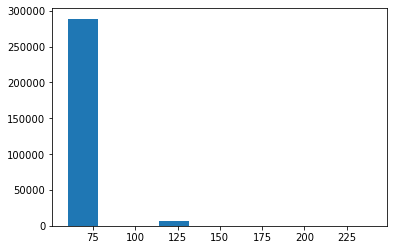

In [42]:
fig, ax = plt.subplots()
ax.hist(durations)

### Network statistics

In [28]:
for frac in fractions:
    G = nx.readwrite.gpickle.read_gpickle(join(network_dst, 
        'university_{}_to_{}_fraction-{}.bz2'\
        .format(str(sample_days[0].date()), str(sample_days[-1].date()), frac)))
    
    N_students = len([n for n in G.nodes(data='type') if n[1] == 'unistudent'])
    N_lecturers = len([n for n in G.nodes(data='type') if n[1] == 'lecturer'])
    
    print('occupancy: {}, lecturers: {}, students: {}'\
          .format(frac * 100, N_lecturers, N_students))

occupancy: 25.0, lecturers: 825, students: 8741
occupancy: 50.0, lecturers: 832, students: 10328
occupancy: 100.0, lecturers: 834, students: 11123


## Create university networks with added or removed contacts

In [7]:
network_src = '../data/networks'
network_name = 'university_2019-10-01_to_2019-10-07_fraction-1.0.bz2'
G = nx.readwrite.gpickle.read_gpickle(join(network_src, network_name))
remove_unistudent_contacts(G, 0.01)

NameError: name 'remove_unistudent_contacts' is not defined

In [16]:
G.get_edge_data(183662, 71873).values()['']

dict_values([{'link_type': 'student_student_group', 'day': '2019-10-01 00:00:00', 'weekday': 2, 'group': 256459, 'contact_type': 'far'}])

In [132]:
len([e for e in G.edges(data=True) if e[2]['weekday'] == 6])

427

In [153]:
reload(ncf)
fractions = [0.25, 0.5, 1.0]
mod_levels = [0.01, 0.05, 0.1, 0.2, 0.5]
network_dst = '../data/networks'
all_days = list(dates['date'].unique())
all_days = [pd.to_datetime(sd) for sd in all_days]
all_days.sort()
sample_days = all_days[0:7]

contact_map = {
    'student_lecturer_group':'far', 
    'student_student_group':'far',
    'student_student_additional':'far'
}

for frac in fractions:
    for level in mod_levels:
        # create the full contact network for the whole university with a given
        # fraction of studence in presence
        G = ncf.create_network(students, lecturers, studies, organisations, 
                                      dates, rooms, sample_days, frac=frac)

        # remove disconnected
        N = len(G.nodes())
        G.remove_nodes_from(list(nx.isolates(G)))
        print('removed {} disconnected nodes'.format(N - len(G.nodes())))
        
        # keep only biggest connected component
        N = len(G.nodes())
        Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
        G = G.subgraph(Gcc[0])
        print('removed {} nodes which were not in the biggest component'\
              .format(N - len(G.nodes())))

        G_plus = ncf.add_unistudent_contacts(G.copy(), level)
        G_minus = ncf.remove_unistudent_contacts(G.copy(), level)

        # map link types to contact strengths
        ncf.map_contacts(G_pus, contact_map)
        ncf.map_contacts(G_minus, contact_map)

        # save the graph
        nx.readwrite.gpickle.write_gpickle(G_plus, join(network_dst,
            'university_{}_to_{}_fraction-{}_add-{}.bz2'\
           .format(str(sample_days[0].date()),
                   str(sample_days[-1].date()),
                   frac,
                   level)), protocol=4)
        
        nx.readwrite.gpickle.write_gpickle(G_minus, join(network_dst,
            'university_{}_to_{}_fraction-{}_rem-{}.bz2'\
           .format(str(sample_days[0].date()),
                   str(sample_days[-1].date()),
                   frac,
                   level)), protocol=4)

removing 6/17 students from room with 44 seats (occupancy 25%)
removing 185/202 students from room with 68 seats (occupancy 25%)
removing 16/23 students from room with 30 seats (occupancy 25%)
removing 5/12 students from room with 30 seats (occupancy 25%)
removing 9/14 students from room with 20 seats (occupancy 25%)
removing 24/71 students from room with 190 seats (occupancy 25%)
removing 11/18 students from room with 30 seats (occupancy 25%)
removing 123/198 students from room with 301 seats (occupancy 25%)
removing 45/120 students from room with 301 seats (occupancy 25%)
removing 16/28 students from room with 49 seats (occupancy 25%)
removing 4/15 students from room with 45 seats (occupancy 25%)
removing 19/25 students from room with 24 seats (occupancy 25%)
removing 40/69 students from room with 119 seats (occupancy 25%)
removing 26/34 students from room with 32 seats (occupancy 25%)
removing 27/36 students from room with 36 seats (occupancy 25%)
removing 12/15 students from room w

KeyboardInterrupt: 

### Network statistics

In [205]:
for frac in fractions:
    G = nx.readwrite.gpickle.read_gpickle(join(network_dst, 
        'university_{}_to_{}_fraction-{}.bz2'\
        .format(str(sample_days[0].date()), str(sample_days[-1].date()), frac)))
    
    N_students = len([n for n in G.nodes(data='type') if n[1] == 'unistudent'])
    N_lecturers = len([n for n in G.nodes(data='type') if n[1] == 'lecturer'])
    
    print('occupancy: {}, lecturers: {}, students: {}'\
          .format(frac * 100, N_lecturers, N_students))

occupancy: 25.0, lecturers: 831, students: 8864
occupancy: 50.0, lecturers: 835, students: 10404
occupancy: 100.0, lecturers: 839, students: 11242
